In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
from astropy.table import Table
from ipywidgets import Button, Layout, jslink, IntText, IntSlider, interactive, interact, HBox, Layout, VBox
import ipywidgets as widgets
import numpy as np
from scipy import interpolate


cat = Table.read("FlightPrincipalCatalog_v5_tronc.csv")#
for c in cat.colnames:
    cat.rename_column(c,c.replace(" ","_").split("[")[0])
cat = cat.to_pandas()


# cat["altitude"] = cat["altitudes[Feets]"]
# cat["EMCCDBack"] = cat["EMCCDBack[C]"]
# cat["Coldhead"] = cat["Coldhead[C]"]
# cat["Reject"] = cat["Reject[C]"]
# cat["Mins_after_launch"] = cat["Mins after launch"]
# Getter, 

x = "SECONDS_TU"
x = "Mins_after_launch"

for col in ["EMGAIN","N_CR","EXPTIME"]:
    cat[col.lower()] = interpolate.interp1d(cat[x][cat["IMNO"]>1], cat[col][cat["IMNO"]>1], kind="nearest",fill_value="extrapolate")(cat[x])
    # test = interpolate.interp1d(cat[x], cat[col], kind="nearest")(cat[x])
    # print(test)


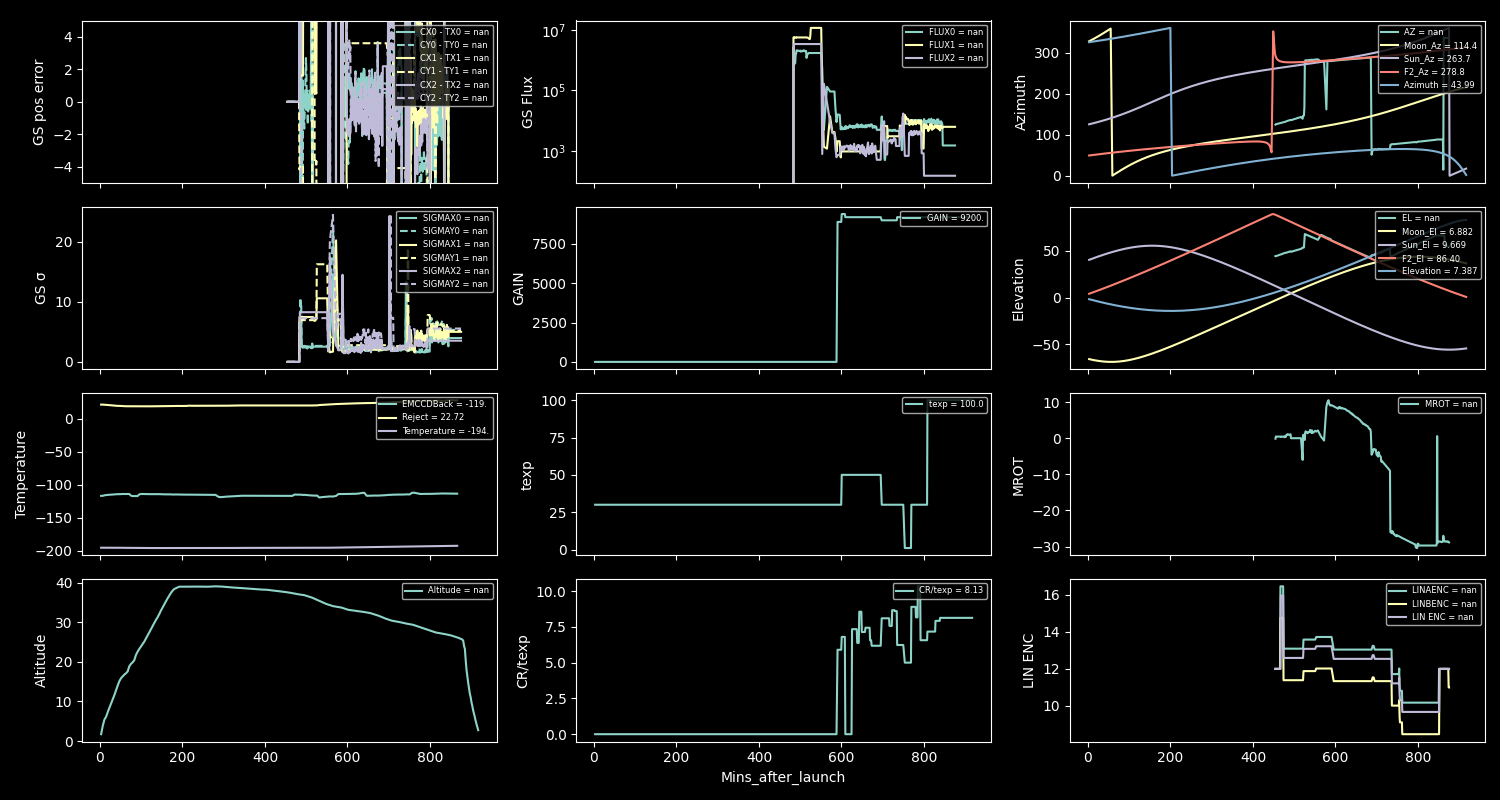

In [2]:




def add_line(cat, y, ax, i=0, x=x, init=True,l=None,change=False, ylabel=None, log=False,ylim=None, **kwargs):
    if ylabel is None:
        ylabel = y
    if "0/0"  in y:
        label = None
    else:
        try:
            label = ylabel.replace(" * 1","") + " = %.5s"%(cat.eval(y)[i])
        except KeyError as e:
            label = None#ylabel
    # print(label)
    if init:
        if log:
            l = ax.semilogy(cat.eval(x),cat.eval(y), **kwargs)
        else:
            l = ax.plot(cat.eval(x),cat.eval(y), **kwargs)
        if ylim is not None:
            ax.set_ylim(ylim)
        ax.set_ylabel(ylabel)
    if change:
        l[0].set_data(cat.eval(x),cat.eval(y))
    l[0].set_label(label)
    if label is not None:
       ax.legend(loc="upper right", fontsize=6)
    return l


style={}#{'description_width': 'initial'} 
width = '400px'
continuous_update=True


class dashboard(widgets.HBox):
     
    def __init__(self,cat=cat,x=x):
        super().__init__()
        self.output = widgets.Output()
        
        # self.ax1bis = self.ax1.twinx()

        self.fig, self.axes = plt.subplots(4,3, figsize=(15,8),sharex=True)
        self.cat=cat
        # (self.a0,self.a1,self.a2,self.a3) = self.axes
        a0, a1, a2, a3 = self.axes
        a3[1].set_xlabel(x)
        # a0[1].sharex(a0[0])
        # a0[0].get_shared_x_axes().join(a0[0],a0[1])
        self.la000 =  add_line(cat,"CX0 - TX0",ax=a0[0])
        self.la001 =  add_line(cat,"CY0 - TY0",ax=a0[0],c=self.la000[0].get_color(),ls="--")
        self.la002 =  add_line(cat,"CX1 - TX1",ax=a0[0],)
        self.la003 =  add_line(cat,"CY1 - TY1",ax=a0[0],c=self.la002[0].get_color(),ls="--")
        self.la004 =  add_line(cat,"CX2 - TX2",ax=a0[0],)
        self.la005 =  add_line(cat,"CY2 - TY2",ax=a0[0],c=self.la004[0].get_color(),ls="--")
        self.la006 =  add_line(cat,"CX3*0/0",ax=a0[0],)
        self.la007 =  add_line(cat,"CY3*0/0",ax=a0[0],c=self.la006[0].get_color(),ls="--")
        self.la008 =  add_line(cat,"CX4*0/0",ax=a0[0],)
        self.la009 =  add_line(cat,"CY4*0/0",ax=a0[0],c=self.la008[0].get_color(),ls="--")
        self.la0010 = add_line(cat,"CX5*0/0",ax=a0[0],)
        self.la0011 = add_line(cat,"CY5*0/0",ax=a0[0],c=self.la0010[0].get_color(),ls="--")
        self.la0012 = add_line(cat,"CX6*0/0",ax=a0[0],)
        self.la0013 = add_line(cat,"CY6*0/0",ax=a0[0],c=self.la0012[0].get_color(),ls="--")
        self.la0014 = add_line(cat,"CX7*0/0",ax=a0[0],)
        self.la0015 = add_line(cat,"CY7*0/0",ax=a0[0],c=self.la0014[0].get_color(),ls="--", ylabel="GS pos error",ylim=[-5,5])



        self.la010 =  add_line(cat,"SIGMAX0",ax=a1[0],)
        self.la011 =  add_line(cat,"SIGMAY0",ax=a1[0],ls="--",c=self.la010[0].get_color())
        self.la012 =  add_line(cat,"SIGMAX1",ax=a1[0],)
        self.la013 =  add_line(cat,"SIGMAY1",ax=a1[0],ls="--",c=self.la012[0].get_color())
        self.la014 =  add_line(cat,"SIGMAX2",ax=a1[0],)
        self.la015 =  add_line(cat,"SIGMAY2",ax=a1[0],ls="--",c=self.la014[0].get_color())
        self.la016 =  add_line(cat,"SIGMAX3*0/0",ax=a1[0],)
        self.la017 =  add_line(cat,"SIGMAY3*0/0",ax=a1[0],ls="--",c=self.la016[0].get_color())
        self.la018 =  add_line(cat,"SIGMAX4*0/0",ax=a1[0],)
        self.la019 =  add_line(cat,"SIGMAY4*0/0",ax=a1[0],ls="--",c=self.la018[0].get_color())
        self.la0110 = add_line(cat,"SIGMAX5*0/0",ax=a1[0],)
        self.la0111 = add_line(cat,"SIGMAY5*0/0",ax=a1[0],ls="--",c=self.la0110[0].get_color())
        self.la0112 = add_line(cat,"SIGMAX6*0/0",ax=a1[0],)
        self.la0113 = add_line(cat,"SIGMAY6*0/0",ax=a1[0],ls="--",c=self.la0112[0].get_color())
        self.la0114 = add_line(cat,"SIGMAX7*0/0",ax=a1[0],)
        self.la0115 = add_line(cat,"SIGMAY7*0/0",ax=a1[0],ls="--",c=self.la0114[0].get_color(), ylabel="GS σ")


        self.la100 = add_line(cat,"FLUX0",    ax=a0[1],log=True,)
        self.la101 = add_line(cat,"FLUX1",    ax=a0[1],log=True,)
        self.la102 = add_line(cat,"FLUX2",    ax=a0[1],log=True,)
        self.la103 = add_line(cat,"FLUX3*0/0",ax=a0[1],log=True,)
        self.la104 = add_line(cat,"FLUX4*0/0",ax=a0[1],log=True,)
        self.la105 = add_line(cat,"FLUX5*0/0",ax=a0[1],log=True,)
        self.la105 = add_line(cat,"FLUX5*0/0",ax=a0[1],log=True,)
        self.la106 = add_line(cat,"FLUX6*0/0",ax=a0[1],log=True,)
        self.la107 = add_line(cat,"FLUX7*0/0",ax=a0[1],log=True, ylabel="GS Flux")


        self.la200 = add_line(cat,"EMCCDBack",ax=a2[0],)
        self.la201 = add_line(cat,"Reject",ax=a2[0],)
        self.la202 = add_line(cat,"Coldhead",ax=a2[0], ylabel="Temperature")

        self.la30 = add_line(cat,"altitudes * 0.3048 / 1000",ax=a3[0],ylabel="Altitude")
        self.la310 = add_line(cat,y="n_cr[n_cr<2000]/exptime[n_cr<2000]",ax=a3[1],x="Mins_after_launch[n_cr<2000]",ylabel="CR/texp")
        # self.la21 = add_line(cat,y="exptime[IMNO>1]",ax=a2[1],x="Mins_after_launch[IMNO>1]",ylabel="texp")
        self.la21 = add_line(cat,y="exptime",ax=a2[1],x="Mins_after_launch",ylabel="texp")
        # self.la11 = add_line(cat,y="EMGAIN[IMNO>1]",ax=a1[1],x="Mins_after_launch[IMNO>1]",ylabel="GAIN")
        self.la11 = add_line(cat,y="emgain",ax=a1[1],x="Mins_after_launch",ylabel="GAIN")
        self.la320 = add_line(cat,y="LINAENC",ax=a3[2])
        self.la321 = add_line(cat,y="LINBENC",ax=a3[2])
        self.la322 = add_line(cat,y="LINCENC",ax=a3[2], ylabel="LIN ENC")
        self.la020 = add_line(cat,"AZ",ax=a0[2])
        self.la021 = add_line(cat,"Moon_Az",ax=a0[2])
        self.la022 = add_line(cat,"Sun_Az",ax=a0[2])
        self.la023 = add_line(cat,"F2_Az",ax=a0[2])
        self.la024 = add_line(cat,"m31_Az",ax=a0[2], ylabel="Azimuth")
        self.la120 = add_line(cat,"EL",ax=a1[2])
        self.la121 = add_line(cat,"Moon_El",ax=a1[2])
        self.la122 = add_line(cat,"Sun_El",ax=a1[2])
        self.la123 = add_line(cat,"F2_El",ax=a1[2])
        self.la124 = add_line(cat,"m31_El",ax=a1[2], ylabel="Elevation")
        self.la22 = add_line(cat,"MROT",ax=a2[2])

        self.vlines = []
        for axes in self.axes:
            for ax in axes:
                line = ax.axvline(x=cat[x][0], color="black", linestyle="--")
                self.vlines.append(line)

        self.fig.tight_layout()


        self.t = widgets.IntSlider( min=0, max=len(cat),value=0, style = style, layout=Layout(width=width),description='t',continuous_update=continuous_update,tooltip="t")
        self.temps = widgets.SelectMultiple(options=["EMCCDBack", 'Reject', 'Coldhead'],value=["EMCCDBack", 'Reject', 'Coldhead'],rows=3,description='Temps',disabled=False)
        self.targets = widgets.SelectMultiple(options=["Moon", 'Sun', 'F2',"m31"],value=["Moon", 'Sun', 'F2',"m31"],rows=4,description='Targets',disabled=False)
        self.GS = widgets.SelectMultiple(options=[0, 1, 2, 3, 4,5 ,6 ,7],value=[0, 1, 2],rows=4,description='GS',disabled=False)
        self.xlim = widgets.Select(options=["all", 'flight', 'UV',"F2"],value="all",rows=5,description='Temps',disabled=False)
#         self.RN = widgets.IntSlider( min=0, max=120,value=RN, style = style, layout=Layout(width=width),description='Read noise',continuous_update=continuous_update,tooltip="EMCCD readout noise in electrons")
#         self.CIC_charge = widgets.FloatSlider( min=0, max=0.05,value=CIC_charge,style = style, layout=Layout(width=width),description='CIC charge',step=0.001,readout_format='.3f',continuous_update=continuous_update,tooltip="EMCCD spurious charges due to amplification in electrons")
#         self.Dard_current = widgets.FloatSlider( min=0, max=2,value=Dard_current, style = style, layout=Layout(width=width),description='Dard current',step=0.0011,readout_format='.2f',continuous_update=continuous_update,tooltip="Dark current of the EMCCD in electrons per hour")
#         self.readout_time = widgets.FloatSlider( min=0, max=20,value=readout_time, style = style, layout=Layout(width=width),description=r'RO time (s)',step=0.1,continuous_update=continuous_update,tooltip="Readout time of the EMCCD controller in seconds")
#         self.x_axis=widgets.Dropdown(options=["Spectra 1538p477","Spectra 1821p643",'Spectra 0044p030',"Spectra mrk509","Spectra 2344p092","Spectra 1637p574","Spectra 1115p080","Spectra 0414m060","Spectra 0115p027","Spectra 2251p113","Spectra 2201p315","Spectra 1928p738","Spectra 1700p518",'fesc=10%, slit=100mu, w=204','fesc= 1%, slit=100mu, w=204','Spectra m=7','Spectra m=10','Spectra m=12','Spectra m=14','Spectra m=15','Spectra m=15','Spectra m=16','Spectra m=17','Spectra m=17.5','Spectra m=18','Spectra m=19','Spectra m=20','Spectra m=22','Spectra m=24','fesc=10%, slit= 50mu, w=204','fesc= 1%, slit= 50mu, w=204','fesc=10%, slit=300mu, w=204','fesc= 1%, slit=300mu, w=204','fesc=10%, slit=100mu, w=200','fesc=10%, slit= 50mu, w=200','fesc=10%, slit=300mu, w=200','fesc=10%, slit=100mu, w=208','fesc=10%, slit= 50mu, w=208','fesc=10%, slit=300mu, w=208'], layout=Layout(width='350px'),description='Entry',value=x_axis)


#         self.fwhm = widgets.FloatRangeSlider( min=0.1, max=6,value=(PSF_RMS_mask,PSF_RMS_det),style = style, layout=Layout(width=width),description='Mask/det σ',step=0.1,readout_format='.1f',tooltip="Spatial resolution in arcseconds respectively at the mask and detector level. To be multiplied by 2.35 to have the FWHM.")
#         self.QE = widgets.FloatSlider( min=0, max=1,value=new.QE,style = style, layout=Layout(width=width),description='QE',step=0.01,readout_format='.2f',tooltip="EMCCD quantum efficiency in percents")
#         self.guider_noise = widgets.FloatSlider( min=0, max=3,value=guider_noise,style = style, layout=Layout(width=width),description='Guider noise',step=0.2,readout_format='.1f',tooltip="Guider induced background level in electrons per hour")

#         self.counting_mode = widgets.Checkbox(value=counting_mode,description='Counting',disabled=False,tooltip="Check this box to apply thresholding photon counting processing. The efficiency of this process is determined by the gain, read noise, smearing, flux.",layout=Layout(width="187px"))


        
#         self.threshold = widgets.FloatSlider( min=-1.1, max=30.1,value=5.5, style = style, layout=Layout(width="347px"),description='Threshold',continuous_update=continuous_update,readout_format='.1f',step=0.1,tooltip="Threshold (n) used when photon counting mode: T=bias+nσ.")
#         self.threshold.layout.visibility ='hidden'
#         self.smearing = widgets.FloatSlider( min=0, max=2,value=smearing, layout=Layout(width=width),description='Smearing',step=0.01,continuous_update=continuous_update)#'$t_{aq}$ (h)') #widgets.Dropdown(options=[0.2,0.7,1.2],value=0.7,description='Smearing (pix)')      
# # 
        wids = widgets.interactive(self.update,t=self.t,temps=self.temps,targets=self.targets,xlim=self.xlim,GS=self.GS)
        controls = VBox([HBox([self.t,self.temps,self.targets,self.xlim,self.GS])] )
        display(HBox([self.output,controls]))

        


    def update(self,t,temps,targets,xlim,GS ):
        """Draw line in plot"""


        with self.output:
            a0, a1, a2, a3 = self.axes



        # self.vlines = []
            for line in  self.vlines:
                line.set_xdata(self.cat[x][t])
        # for axes in self.axes:
        #     for ax in axes:
        #         line = ax.axvline(x=cat[x][0], color="black", linestyle="--")
        #         self.vlines.append(line)


            # self.fig.axes[2].relim()
            # self.fig.axes[2].autoscale_view()
            # self.ax1bis.relim()
            if xlim == "all":
                for a in a0:
                    a.set_xlim((np.nanmin(cat[x]),np.nanmax(cat[x])))
            elif xlim=="flight":
                for a in a0:
                    a.set_xlim((50,150))
            elif xlim=="F2":
                for a in a0:
                    a.set_xlim((600,680))
            elif xlim== "UV":
                for a in a0:
                    a.set_xlim((500,850))
            add_line(cat,"(CX0 - TX0) * %s"%(1 if 0 in GS else "0/0"),ax=a0[0],i=t, init=False,l= self.la000 ,change=True)
            add_line(cat,"(CY0 - TY0) * %s"%(1 if 0 in GS else "0/0"),ax=a0[0],i=t, init=False, l=self.la001 ,change=True)
            add_line(cat,"(CX1 - TX1) * %s"%(1 if 1 in GS else "0/0"),ax=a0[0],i=t, init=False,l= self.la002 ,change=True)
            add_line(cat,"(CY1 - TY1) * %s"%(1 if 1 in GS else "0/0"),ax=a0[0],i=t, init=False, l=self.la003 ,change=True)
            add_line(cat,"(CX2 - TX2) * %s"%(1 if 2 in GS else "0/0"),ax=a0[0],i=t, init=False,l= self.la004 ,change=True)
            add_line(cat,"(CY2 - TY2) * %s"%(1 if 2 in GS else "0/0"),ax=a0[0],i=t, init=False, l=self.la005 ,change=True)
            add_line(cat,"(CX3 - TX3) * %s"%(1 if 3 in GS else "0/0"),ax=a0[0],i=t, init=False,l= self.la006 ,change=True)
            add_line(cat,"(CY3 - TY3) * %s"%(1 if 3 in GS else "0/0"),ax=a0[0],i=t, init=False, l=self.la007 ,change=True)
            add_line(cat,"(CX4 - TX4) * %s"%(1 if 4 in GS else "0/0"),ax=a0[0],i=t, init=False,l= self.la008 ,change=True)
            add_line(cat,"(CY4 - TY4) * %s"%(1 if 4 in GS else "0/0"),ax=a0[0],i=t, init=False, l=self.la009 ,change=True)
            add_line(cat,"(CX5 - TX5) * %s"%(1 if 5 in GS else "0/0"),ax=a0[0],i=t, init=False,l= self.la0010,change=True)
            add_line(cat,"(CY5 - TY5) * %s"%(1 if 5 in GS else "0/0"),ax=a0[0],i=t, init=False, l=self.la0011,change=True)
            add_line(cat,"(CX6 - TX6) * %s"%(1 if 6 in GS else "0/0"),ax=a0[0],i=t, init=False,l= self.la0012,change=True)
            add_line(cat,"(CY6 - TY6) * %s"%(1 if 6 in GS else "0/0"),ax=a0[0],i=t, init=False, l=self.la0013,change=True)
            add_line(cat,"(CX7 - TX7) * %s"%(1 if 7 in GS else "0/0"),ax=a0[0],i=t, init=False,l= self.la0014,change=True)
            add_line(cat,"(CY7 - TY7) * %s"%(1 if 7 in GS else "0/0"),ax=a0[0],i=t, init=False, l=self.la0015,change=True)


            add_line(cat,"SIGMAX0 * %s"%(1 if 0 in GS else "0/0"),ax=a1[0],i=t, init=False,l= self.la010 ,change=True)
            add_line(cat,"SIGMAY0 * %s"%(1 if 0 in GS else "0/0"),ax=a1[0],i=t, init=False, l=self.la011 ,change=True)
            add_line(cat,"SIGMAX1 * %s"%(1 if 1 in GS else "0/0"),ax=a1[0],i=t, init=False,l= self.la012 ,change=True)
            add_line(cat,"SIGMAY1 * %s"%(1 if 1 in GS else "0/0"),ax=a1[0],i=t, init=False, l=self.la013 ,change=True)
            add_line(cat,"SIGMAX2 * %s"%(1 if 2 in GS else "0/0"),ax=a1[0],i=t, init=False,l= self.la014 ,change=True)
            add_line(cat,"SIGMAY2 * %s"%(1 if 2 in GS else "0/0"),ax=a1[0],i=t, init=False, l=self.la015 ,change=True)
            add_line(cat,"SIGMAX3 * %s"%(1 if 3 in GS else "0/0"),ax=a1[0],i=t, init=False,l= self.la016 ,change=True)
            add_line(cat,"SIGMAY3 * %s"%(1 if 3 in GS else "0/0"),ax=a1[0],i=t, init=False, l=self.la017 ,change=True)
            add_line(cat,"SIGMAX4 * %s"%(1 if 4 in GS else "0/0"),ax=a1[0],i=t, init=False,l= self.la018 ,change=True)
            add_line(cat,"SIGMAY4 * %s"%(1 if 4 in GS else "0/0"),ax=a1[0],i=t, init=False, l=self.la019 ,change=True)
            add_line(cat,"SIGMAX5 * %s"%(1 if 5 in GS else "0/0"),ax=a1[0],i=t, init=False,l= self.la0110,change=True)
            add_line(cat,"SIGMAY5 * %s"%(1 if 5 in GS else "0/0"),ax=a1[0],i=t, init=False, l=self.la0111,change=True)
            add_line(cat,"SIGMAX6 * %s"%(1 if 6 in GS else "0/0"),ax=a1[0],i=t, init=False,l= self.la0112,change=True)
            add_line(cat,"SIGMAY6 * %s"%(1 if 6 in GS else "0/0"),ax=a1[0],i=t, init=False, l=self.la0113,change=True)
            add_line(cat,"SIGMAX7 * %s"%(1 if 7 in GS else "0/0"),ax=a1[0],i=t, init=False,l= self.la0114,change=True)
            add_line(cat,"SIGMAY7 * %s"%(1 if 7 in GS else "0/0"),ax=a1[0],i=t, init=False, l=self.la0115,change=True)

            add_line(cat,"FLUX0 * %s"%(1 if 0 in GS else "0/0"),ax=a0[1],i=t, init=False,l= self.la100,change=True)
            add_line(cat,"FLUX1 * %s"%(1 if 1 in GS else "0/0"),ax=a0[1],i=t, init=False, l=self.la101,change=True)
            add_line(cat,"FLUX2 * %s"%(1 if 2 in GS else "0/0"),ax=a0[1],i=t, init=False,l= self.la102,change=True)
            add_line(cat,"FLUX3 * %s"%(1 if 3 in GS else "0/0"),ax=a0[1],i=t, init=False, l=self.la103,change=True)
            add_line(cat,"FLUX4 * %s"%(1 if 4 in GS else "0/0"),ax=a0[1],i=t, init=False,l= self.la104,change=True)
            add_line(cat,"FLUX5 * %s"%(1 if 5 in GS else "0/0"),ax=a0[1],i=t, init=False, l=self.la105,change=True)
            add_line(cat,"FLUX6 * %s"%(1 if 6 in GS else "0/0"),ax=a0[1],i=t, init=False, l=self.la106,change=True)
            add_line(cat,"FLUX7 * %s"%(1 if 7 in GS else "0/0"),ax=a0[1],i=t, init=False, l=self.la107,change=True)


            add_line(cat,"EMCCDBack * %s"%(1 if "EMCCDBack" in temps else "0/0"),ax=a2[0],i=t, init=False,l= self.la200,change=True)
            add_line(cat,"Reject * %s"%(1 if "Reject" in temps else "0/0"),ax=a2[0],i=t, init=False, l=self.la201,change=True)
            add_line(cat,"Coldhead * %s"%(1 if "Coldhead" in temps else "0/0"),ax=a2[0],i=t, init=False, l=self.la202,change=True)
            a2[0].relim()
            a2[0].autoscale_view()

            add_line(cat,"altitudes * 0.3048 / 1000",ax=a3[0],i=t, init=False, l=self.la30,ylabel="Altitude")
            add_line(cat,"n_cr/exptime",ax=a3[1],i=t, init=False, l=self.la310)
            add_line(cat,"exptime",ax=a2[1],i=t, init=False, l=self.la21 )
            add_line(cat,"emgain",ax=a1[1],i=t, init=False, l=self.la11 )
            add_line(cat,"LINAENC",ax=a3[2],i=t, init=False, l=self.la320)
            add_line(cat,"LINBENC",ax=a3[2],i=t, init=False, l=self.la321)
            add_line(cat,"LINCENC",ax=a3[2],i=t, init=False, l=self.la322)
            add_line(cat,"AZ",ax=a0[2],i=t, init=False, l=self.la020)
            add_line(cat,"Moon_Az * %s"%(1 if "Moon" in targets else "0/0"),ax=a0[2],i=t, init=False, l=self.la021,change=True)
            add_line(cat,"Sun_Az * %s"%(1 if "Sun" in targets else "0/0"),ax=a0[2],i=t, init=False, l=self.la022,change=True)
            add_line(cat,"F2_Az * %s"%(1 if "F2" in targets else "0/0"),ax=a0[2],i=t, init=False, l=self.la023,change=True)
            add_line(cat,"m31_Az * %s"%(1 if "m31" in targets else "0/0"),ax=a0[2],i=t, init=False, l=self.la024,change=True)
            a0[2].relim()
            a0[2].autoscale_view()

            add_line(cat,"EL",ax=a1[2],i=t, init=False, l=self.la120)
            add_line(cat,"Moon_El * %s"%(1 if "Moon" in targets else "0/0"),ax=a1[2],i=t, init=False, l=self.la121,change=True)
            add_line(cat,"Sun_El * %s"%(1 if "Sun" in targets else "0/0"),ax=a1[2],i=t, init=False, l=self.la122,change=True)
            add_line(cat,"F2_El * %s"%(1 if "F2" in targets else "0/0"),ax=a1[2],i=t, init=False, l=self.la123,change=True)
            add_line(cat,"m31_El * %s"%(1 if "m31" in targets else "0/0"),ax=a1[2],i=t, init=False, l=self.la124,change=True)
            a0[2].relim()
            a0[2].autoscale_view()
            add_line(cat,"MROT",ax=a2[2],i=t, init=False, l=self.la22 )
            self.fig.canvas.draw()
            self.axes = a0, a1, a2, a3 
            return 
            # fitswrite(self.im, "/tmp/test_%s.fits"%(fwhm[1]))

d = dashboard(cat)
# add log for GS Flux

Todo:
- put all orders (temperatures, az/el, guiding stars positions)
- add electric consumption?
- add new temperatures
- change to dates x abs
- add some tracer with t
- add BRD-VM_30MS_1-TM-MISSION1-Batterie